# Welcome!

## to Extreme Learning Machine Workshop


by: *Anton Akusok*

Let's go through a story of ELM in Python:  
from basics to the cutting edge applications.

## The Juicy Bits:

1. ELM tools and basics
2. Classification
3. Advanced Tuning

~ Break

5. High-Performance ELM
6. Driving an ELM with manual gearbox

~ Summary

# ELM Code Tools

ELM relies on basic linear algebra. Easy to implement in Python.

- Numpy
- Scikit-Learn
- Scikit-ELM (`skelm`)
- High Performance ELM (`hpelm`)

Which tools do you use?
- Matlab
- Python + Numpy
- Other language or math library
- Scikit-Learn
- hpelm
- skelm
- other ELM library

In [1]:
# Example problem
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)
n, d = X.shape  # number of data samples and features

X.shape, y.shape

((442, 10), (442,))

In [2]:
X[:3]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187239, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, -0.00567042, -0.04559945,
        -0.03419447, -0.03235593, -0.00259226,  0.00286131, -0.02593034]])

In [3]:
y[:3]

array([151.,  75., 141.])

### ELM implementation with different tools

Let's make a basic ELM model in different ways in Python

### Numpy

`y = a*x` linear model  
`y = B*h` in ELM notations

In [6]:
import numpy as np

k = 10  # number of hidden neurons
d = X.shape[1]  # number of data features
W = np.random.randn(d, k)

H = np.tanh(X@W)

# B = np.linalg.pinv(H)@y  # don't use matrix inversion explicitly
B = np.linalg.lstsq(H, y, rcond=None)[0]

y_pred = np.tanh(X@W) @ B
rmse = np.mean((y_pred - y)**2)**0.5

In [7]:
print("RMSE: {:.2f}".format(rmse))

RMSE: 161.36


### Numpy with bias

`y = B*h + bias`  
<==> `y = B*h + bias*1`  
<==> `y = [B bias] * [h 1]`

In [8]:
H = np.tanh(X@W)
H_bias = np.hstack([H, np.ones((n, 1))])
B_bias = np.linalg.lstsq(H_bias, y, rcond=None)[0]

B, bias = B_bias[:-1], B_bias[-1]

y_pred = np.tanh(X@W) @ B + bias
rmse = np.mean((y_pred - y)**2)**0.5

In [9]:
print("RMSE with bias: {:.2f}".format(rmse))

RMSE with bias: 53.55


### Scikit-Learn

In [10]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class TanhTranformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.tanh(X)


model = make_pipeline(
    GaussianRandomProjection(n_components=k),
    TanhTranformer(),
    LinearRegression(fit_intercept=True)
)

In [11]:
y_pred = model.fit(X, y[:, None]).predict(X)
rmse = np.mean((y_pred - y)**2)**0.5

In [12]:
print("RMSE Scikit-Learn: {:.2f}".format(rmse))

RMSE Scikit-Learn: 94.87


### Scikit-ELM

In [13]:
# !pip install scikit-elm

In [14]:
import skelm
from skelm import ELMRegressor

In [15]:
model = ELMRegressor(n_neurons=k, ufunc='tanh')

y_pred = model.fit(X, y).predict(X)
rmse = np.mean((y_pred - y)**2)**0.5

In [16]:
print("RMSE scikit-elm: {:.2f}".format(rmse))

RMSE scikit-elm: 53.52


### HPELM

macOS packages

`!brew install hdf5`  
`!python -m pip install tables`

basic, no GPU:

`!pip install hpelm`

with GPU support

`!pip install numpy==1.21 scikit-cuda hpelm`

In [18]:
from hpelm import HPELM

In [19]:
model = HPELM(inputs=d, outputs=1)
model.add_neurons(k, 'tanh')

model.train(X, y)
y_pred = model.predict(X)
rmse = np.mean((y_pred - y)**2)**0.5

In [20]:
print("RMSE hpelm: {:.2f}".format(rmse))

RMSE hpelm: 94.64


# Math shared by all implementations


All implementations have the fundamental bits:
- input matrix `X` of size [num_samples, num_features]
- output matrix `y` of size [num_samples, num_outputs]
- projection matrix `W` of size [num_features, num_neurons]
- non-linear tranformation function `ufunc` like hyperbolic tangent (`np.tanh`), sigmoid, or any other
- output weights `B` of size [num_neurons, num_outputs]
- optional output bias/intercept of size [num_outputs, ]

ELM formula:
- Projection step `H = ufunc(X @ W)` 
- Solution step `B = solve(H, y)`
- Prediction step `y_pred = ufunc(X_pred @ W) @ B`

Pair-wise ELM:
- `H = ufunc(pairwise(X, W))`
- `y_pred = ufunc(pairwise(X_pred, W)) @ B`

# Improving the solution: Bias

Mathematical formula `Y = A*X` is an affine tranformation, a mix of scaling, rotation, and shear. It preserves the "center of mass" of the points. It cannot solve translation `A*X =/= X+1`.

In ELM problem, an average of `H` is around zero because of non-linear function. If an average of `y` is around zero too, an ELM works great.  
But if an average of `y` is far from zero, ELM may struggle to find a solution.

Bias term learn the translation, and solves the problem of different averages of `H` and `y`.

# Improving the solution: L2-regularisation

Models can overfit and underfit, depending on ratio between model complexity and data complexity. Both reduce predictive performance.

ELM complexity is changed by the number of neurons. We can find an optimal number of neurons.

Linear models have also numerical problems. Output weights `B` can have large magnitude numbers or small magnitude numbers.   
Both produce same solution. They look like:  
- `y = 3`  
- `x = [1, 1, 1]`
- `y = 1*x[0] - 1*x[1] + 3*x[2]`
    - small magnitude `B`, correct answer  
- `y = 1,000,000*x[0] - 1,000,000*x[1] + 3*x[2]` 
    - large magnitude `B`, correct answer

Large magnitude of `B` values make ELM unstable: small changes in input features completely destroy predictions.

L2-regularization term reduces the magnitude of `B` *AND* reduces model complexity.

An alternative approach to ELM complexity balance:
- Increase complexity by taking more neurons than needed
- Decrease complexity *and* magnitude of `B` values by increasing L2-regularisation term

Get an optimal complexity model, with good stability from small magnitude `B` values.

#### How to implement L2-regularization?

- Numpy approach:
    - very simple code trick; on next slides

- Scipy approach:
    - replace `LinearRegression` with `Ridge` that is a linear regression with L2-parameter `alpha`

- Scikit-ELM, HPELM:
    - use `alpha` parameter

In [21]:
# Numpy without L2-regularization

B = np.linalg.pinv(H) @ y
B

array([ 526.59761989,  477.28310069, -242.64892377,   -1.56968609,
        489.59712027,  544.41801764,  290.27645458,  331.61509075,
        314.2878222 , -209.71355016])

In [22]:
# Numpy with L2-regularization
# HB = y  <==>  H'HB = H'y

HH = H.T@H
Hy = H.T@y[:, None]

alpha = 1000
HH_with_L2 = HH + alpha*np.eye(k)  # add `alpha` to diagonal of H'H

B = np.linalg.pinv(HH_with_L2) @ Hy
B.ravel()

array([ 0.99352311, -0.70085966, -1.82391558, -0.9158587 ,  0.78231255,
       -0.79743229,  2.88960444, -1.11449725,  1.79333746,  1.40316471])

In [23]:
# in-place diagonal increase
HH_L2 = HH.copy()
HH_L2.ravel()[::k+1] += alpha

B = np.linalg.pinv(HH_L2) @ Hy
B.ravel()

array([ 0.99352311, -0.70085966, -1.82391558, -0.9158587 ,  0.78231255,
       -0.79743229,  2.88960444, -1.11449725,  1.79333746,  1.40316471])

# Classification

Let's look at basics of ELM classification.

We actually saw regression in the previous chapter.

In [24]:
# Very similar problem - what changed?
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)
n, d = X.shape  # number of data samples and features

X.shape, y.shape

((150, 4), (150,))

In [25]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [26]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Convert classes into multiple binary outputs

In [27]:
y_2d = y[:, None]
Y = np.hstack([y_2d==i for i in range(3)]).astype(int)
Y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

### Multi-output ELM for classification

Multi-output ELM is multiple ELMs with a shared hidden layer, each having an independent output solution.

In [28]:
k = 10  # number of hidden neurons
d = X.shape[1]  # number of data features
W = np.random.randn(d, k)

H = np.tanh(X@W)
H_bias = np.hstack([H, np.ones((n, 1))])
B_bias = np.linalg.pinv(H_bias)@Y

B, bias = B_bias[:-1], B_bias[-1]

Y_raw = np.tanh(X@W) @ B + bias
y_pred = Y_raw.argmax(axis=1)

accuracy = np.mean(y_pred == y)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 96.67%


In [29]:
# Each output feature is an independent problem

B2_bias_parts = [
    np.linalg.pinv(H_bias)@Y[:, i:i+1] 
    for i in range(3)
]
B2_bias = np.hstack(B2_bias_parts)

B, bias = B2_bias[:-1], B2_bias[-1]

Y_raw = np.tanh(X@W) @ B + bias
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == y)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 96.67%


In [30]:
from sklearn.linear_model import Ridge

model = make_pipeline(
    GaussianRandomProjection(n_components=k),
    TanhTranformer(),
    Ridge(fit_intercept=True, alpha=10)
)

Y_raw = model.fit(X, Y).predict(X)
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == y)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 88.67%


### Train/test split

So far we looked at training error - a measure of how well a model can extract information from known data.

Prediction problems needs to know how well a model predicts information for new coming, previously unseen data. 

Test set helps approximating the prediction performance.

In [30]:
from sklearn.model_selection import train_test_split

Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.3)

ys

array([2, 0, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 2, 0, 2, 0, 2, 2,
       1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0,
       0])

In [31]:
Yt = np.hstack([yt[:, None]==i for i in range(3)]).astype(int)

Y_raw = model.fit(Xt, Yt).predict(Xs)
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == ys)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 84.44%


**Beware of cutting data in two - both training and test sets must get a similar mix of data**

In [32]:
Xt, Xs = X[:100], X[100:]
yt, ys = y[:100], y[100:]

In [33]:
yt

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
ys

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

In [35]:
Yt = np.hstack([yt[:, None]==i for i in range(3)]).astype(int)

Y_raw = model.fit(Xt, Yt).predict(Xs)
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == ys)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 0.00%


Correct split by randomly shuffle data before it

In [36]:
index = np.arange(n)
np.random.shuffle(index)

X_shuffle = X[index]  # SAME index for X and y
y_shuffle = y[index]

Xt, Xs = X_shuffle[:100], X_shuffle[100:]
yt, ys = y_shuffle[:100], y_shuffle[100:]

In [37]:
yt

array([0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2,
       2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 2,
       0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 2,
       2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 1, 0])

In [38]:
ys

array([0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 2, 1,
       2, 2, 0, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 1, 1, 1, 1])

In [39]:
Yt = np.hstack([yt[:, None]==i for i in range(3)]).astype(int)

Y_raw = model.fit(Xt, Yt).predict(Xs)
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == ys)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 84.00%


# Scaling

Random projection in ELM is a simple mathematical formula that includes addition. 

If feature A has 100x larger magnitude than feature B, it will be 100x more important after the addition. Small magnitude features are almost ignored.

Non-linear function also requires a specific range of values. Hyperbolic tangent `tanh` is linear in [-0.1, 0.1] and crops to -1 at [-inf, -3] and +1 at [3, +inf]. Best range of `X@W` values are within [-3, -0.1] U [0.1, 3].

In [40]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

Simple scaling

In [41]:
X_norm = (X - X.mean(0)) / X.std(0)

X_norm[:3]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ]])

Automatic scaling

In [42]:
from sklearn.preprocessing import RobustScaler

X_robust = RobustScaler().fit_transform(X)

X_robust[:3]

array([[-0.53846154,  1.        , -0.84285714, -0.73333333],
       [-0.69230769,  0.        , -0.84285714, -0.73333333],
       [-0.84615385,  0.4       , -0.87142857, -0.73333333]])

#### Let's examine values of `H` that go into non-linear function of ELM

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 4)

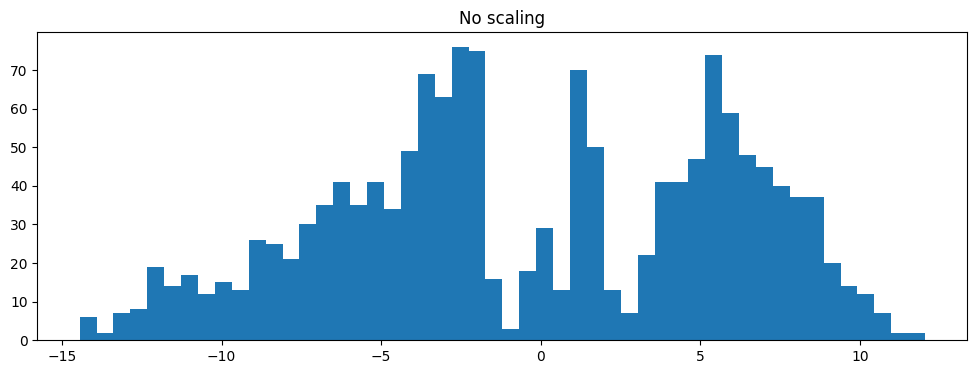

In [44]:
XW = X@W

plt.hist(XW.ravel(), 50)
plt.title("No scaling")
plt.show()

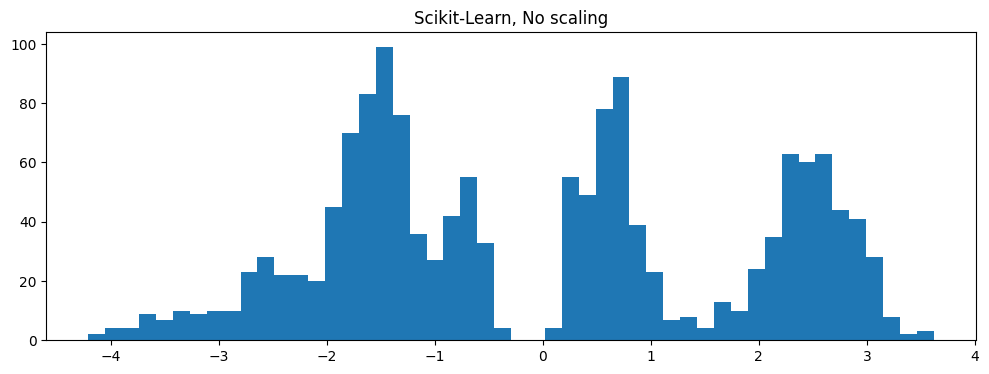

In [45]:
XW_sklearn = GaussianRandomProjection(n_components=k).fit_transform(X)

plt.hist(XW_sklearn.ravel(), 50)
plt.title("Scikit-Learn, No scaling")
plt.show()

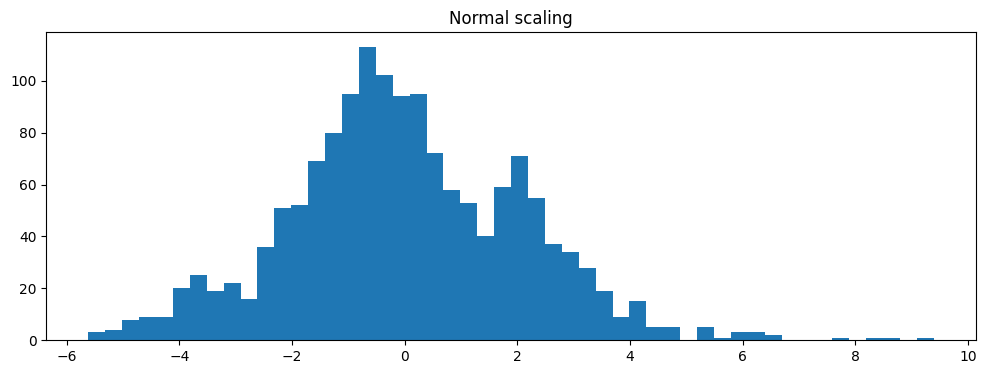

In [46]:
X_norm = (X - X.mean(0)) / X.std(0)
XW_norm = X_norm@W

plt.hist(XW_norm.ravel(), 50)
plt.title("Normal scaling")
plt.show()

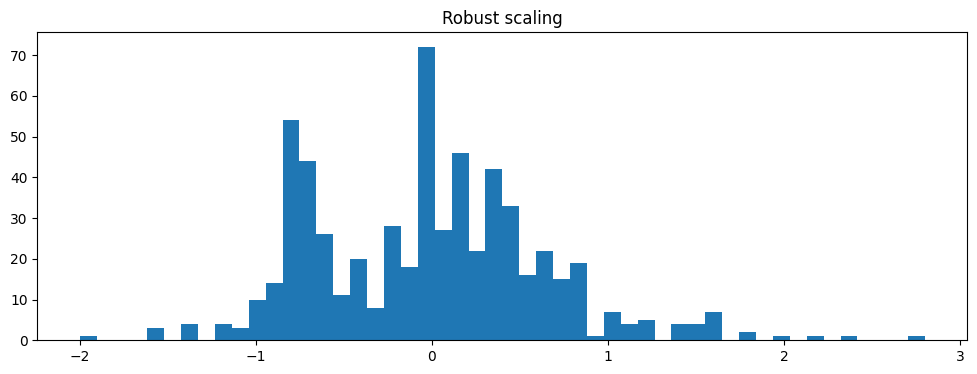

In [47]:
X_robust = RobustScaler().fit_transform(X)
XW_robust = X_robust@W

plt.hist(X_robust.ravel(), 50)
plt.title("Robust scaling")
plt.show()

Fixing scaling in Scikit-Learn

In [48]:
model = make_pipeline(
    RobustScaler(),
    skelm.ELMClassifier(n_neurons=k)
    #GaussianRandomProjection(n_components=k),
    #TanhTranformer(),
    #Ridge(fit_intercept=True, alpha=0.01)
)

Y_raw = model.fit(X, Y).predict(X)
y_pred = Y_raw.argmax(1)

accuracy = np.mean(y_pred == y)
print("Accuracy: {:.2f}%".format(100 * accuracy))

Accuracy: 90.00%


# Advanced Tuning

We can do even better with our models.

In [50]:
import pandas as pd

fortune1k = pd.read_csv("fortune 1000 companies in dec2021.csv").iloc[:, 3:].replace('-', '0')
fortune1k.head()

,Revenue,revenue(% change),profits in millions,profits % change,assets,market value,change in rank in 1000,employees,change in rank(500 only),measure_up_rank
0,"$559,151",0.067,"$13,510",-0.092,"$252,496","$382,642.8",0,2300000,0,20
1,"$386,064",0.376,"$21,331",0.841,"$321,195","$1,558,069.6",0,1298000,0,11
2,"$274,515",0.055,"$57,411",0.039,"$323,888","$2,050,665.9",1,147000,1,188
3,"$268,706",0.046,"$7,179",0.082,"$230,715","$98,653.2",1,256500,1,57
4,"$257,141",0.062,"$15,403",0.113,"$197,289","$351,725",2,330000,2,25


In [51]:
for col in fortune1k.columns:
    if fortune1k[col].dtype == int:
        continue
    fortune1k[col] = fortune1k[col].str.replace("[$,]", "", regex=True).astype(float)

In [52]:
fortune1k.head()

,Revenue,revenue(% change),profits in millions,profits % change,assets,market value,change in rank in 1000,employees,change in rank(500 only),measure_up_rank
0,559151.0,0.067,13510.0,-0.092,252496.0,382642.8,0.0,2300000,0.0,20.0
1,386064.0,0.376,21331.0,0.841,321195.0,1558069.6,0.0,1298000,0.0,11.0
2,274515.0,0.055,57411.0,0.039,323888.0,2050665.9,1.0,147000,1.0,188.0
3,268706.0,0.046,7179.0,0.082,230715.0,98653.2,1.0,256500,1.0,57.0
4,257141.0,0.062,15403.0,0.113,197289.0,351725.0,2.0,330000,2.0,25.0


# Log Scale: the missing `mean`

In [53]:
from sklearn.metrics import r2_score

In [54]:
X, y = fortune1k.iloc[:, 1:], fortune1k.iloc[:,0]
Xt, Xs, yt, ys = train_test_split(X, y, train_size=0.3)

model = skelm.ELMRegressor().fit(Xt, yt)
ys_pred = model.predict(Xs)

score = r2_score(y_true=ys, y_pred=ys_pred)
print("R2 score:", score)

R2 score: -0.6314471128178987


### Let's examine the mean values

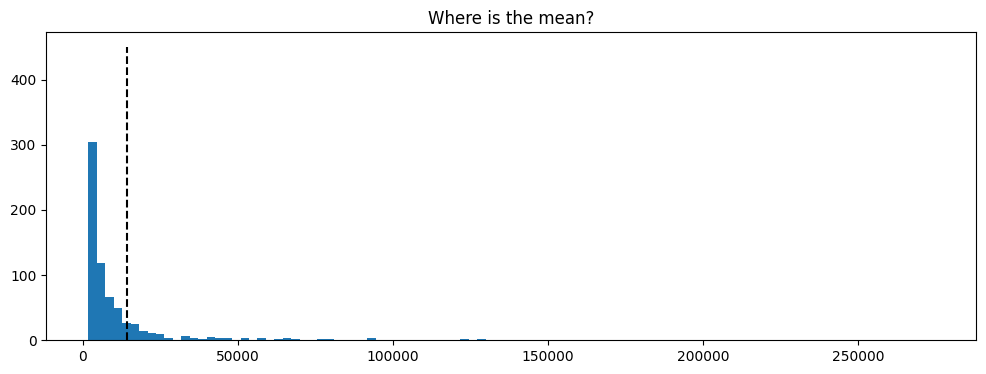

In [55]:
plt.hist(ys, 100)
m = np.mean(ys)
plt.plot([m, m], [0, 450], '--k')
plt.title("Where is the mean?")
plt.show()

Logarithmically distributed variables have no concept of `mean`.   

Very common in real world - income, followers, noise and light levels, etc.

Taking `log(value)` fixes the missing mean problem.

(This dataset is "top-1000" companies. It looks like a tail of normal distribution because it is a tail of normal distribution.)

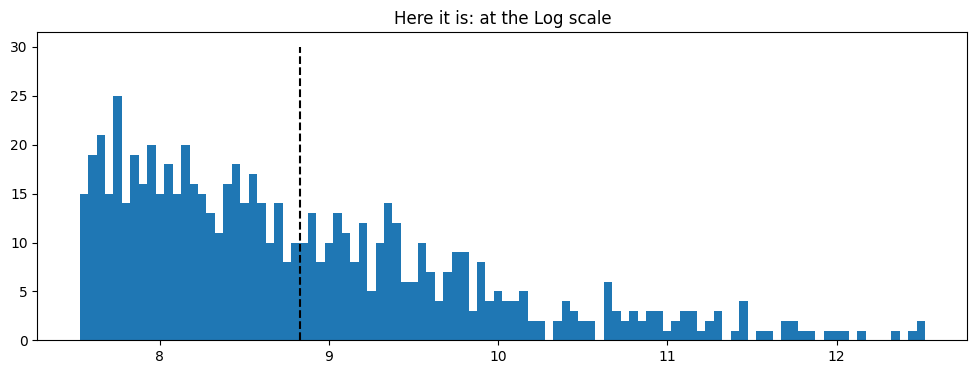

In [56]:
plt.hist(np.log(ys), 100)
m = np.mean(np.log(ys))
plt.plot([m, m], [0, 30], '--k')
plt.title("Here it is: at the Log scale")
plt.show()

### Scale input features

In [57]:
X, y = fortune1k.iloc[:, 1:], fortune1k.iloc[:,0]
for col in ['profits in millions', 'assets', 'market value', 
            'employees', 'measure_up_rank']:
    val = X[col]
    X[col] = np.sign(val) * np.log(np.abs(val) + 1)  # "negative" log values
    
Xt, Xs, yt, ys = train_test_split(X, y, train_size=0.3)

model = skelm.ELMRegressor().fit(Xt, yt)
ys_pred = model.predict(Xs)

score = r2_score(y_true=ys, y_pred=ys_pred)
print("R2 score:", score)

R2 score: -0.40434389195111264


Did not really help...

### Scale *output*  features too!

In [58]:
fortune1k_log = fortune1k.copy()
for col in ['Revenue', 'profits in millions', 'assets', 'market value', 
            'employees', 'measure_up_rank']:
    val = fortune1k_log[col]
    fortune1k_log[col] = np.sign(val) * np.log(np.abs(val) + 1)

In [59]:
X, y = fortune1k_log.iloc[:, 1:], fortune1k_log.iloc[:,0]
Xt, Xs, yt, ys = train_test_split(X, y, train_size=0.3)

model = skelm.ELMRegressor(n_neurons=20).fit(Xt, yt)
ys_pred = model.predict(Xs)

score = r2_score(y_true=ys, y_pred=ys_pred)
print("R2 score:", score)

R2 score: 0.33573535646787


It worked!

ELM output is a linear model.

Linear model is a mapping between two values: `HB = Y`.  
It is fully reversible: `H = YB^-1`.  

If *either* of the values `H`, `Y` is poorly scaled, the model does not work.  
Scale *both* inputs and outputs.

# High-Performance ELM: `hpelm`

An older interface model that does not play well with Scikit-Learn. 

Insane power, GPU, low compute overhead.

In [60]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True)

X.shape, y.shape

((20640, 8), (20640,))

In [61]:
n, d = X.shape
d_out = 1
k = 1000

In [62]:
model = HPELM(d, d_out, precision='single', norm=1e-5)

model.add_neurons(number=k//2, func="tanh")
model.add_neurons(number=k//2, func="rbf_l2")

In [63]:
model.train(X, y)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/Users/akusok/.pyenv/versions/jupyter/lib/python3.11/site-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


In [64]:
yh = model.predict(X)

r2_score(y, yh)

0.19053946855741655

### Sensible to data normalization

In [65]:
X = (X - X.mean(0)) / X.std(0)
y = y - y.mean()  # no bias at the moment

In [66]:
model.train(X, y)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/Users/akusok/.pyenv/versions/jupyter/lib/python3.11/site-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


In [67]:
yh = model.predict(X)

r2_score(y, yh)

-74.67351738732994

### HP-ELM Classification

In [68]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True)

In [69]:
X.shape, y.shape

((581012, 54), (581012,))

In [70]:
set(y)

{1, 2, 3, 4, 5, 6, 7}

Transform outputs into one-hot encoding

In [71]:
y_2d = y[:, None]
Y = np.hstack([y_2d==i for i in (1,2,3,4,5,6,7)]).astype(int)
Y.shape

(581012, 7)

In [72]:
n, d = X.shape
d_out = Y.shape[1]
k = 200

Classification types:
- 'c' for classification
- 'wc' for weighted classification
- 'ml' for multi-label classification

In [73]:
model = HPELM(d, d_out, classification='c', norm=1e-5)

model.add_neurons(number=k, func="tanh")

In [74]:
model.train(X, Y)

In [75]:
from sklearn.metrics import f1_score

Yh = model.predict(X)
yh = Yh.argmax(1) + 1

In [76]:
f1_score(y, yh, average='micro')

0.5345173593660716

# ELM in manual gearbox

### Two-stage solution with H'H matrix

A trick to large-scale ELM is to remove data sample size `n` variable from the calculations.

Then we don't care how much data there is.

![](img/HH1.png)

This trick allows us to update previously trained model!

![](img/HH2.png)

In [77]:
model = HPELM(d, d_out, classification='c', norm=1e-5)

model.add_neurons(number=k, func="tanh")

In [78]:
model.add_data(X[0::3], Y[0::3])
model.nnet.HH[:3, :3]

array([[ 193671.00001   , -193671.        ,  193309.86973206],
       [      0.        ,  193671.00001   , -193309.86973206],
       [      0.        ,       0.        ,  193663.63976635]])

In [79]:
model.add_data(X[1::3], Y[1::3])
model.add_data(X[2::3], Y[2::3])
model.nnet.HH[:3, :3]

array([[ 581012.00001   , -581012.        ,  579923.82893852],
       [      0.        ,  581012.00001   , -579923.82893852],
       [      0.        ,       0.        ,  580993.64932834]])

In [80]:
model.nnet.solve()

In [81]:
Yh = model.predict(X)
yh = Yh.argmax(1) + 1

f1_score(y, yh, average='micro')

0.5509335435412693

### `HH, HY` matrices in `scikit-elm`

In [82]:
model = skelm.ELMClassifier(n_neurons=k, ufunc='tanh')

model.partial_fit(X[0::3], Y[0::3], compute_output_weights=False)

ELMClassifier(n_neurons=200)

In [87]:
model.SLFNs_

[HiddenLayer(n_neurons=200)]

In [88]:
layer = model.SLFNs_[0]

layer.transform, layer.ufunc_

(<bound method HiddenLayer.transform of HiddenLayer(n_neurons=200)>,
 <ufunc 'tanh'>)

In [89]:
H = layer.ufunc_(layer.transform(X[0::3]))
HH = H.T @ H
HY = H.T @ Y[0::3]

In [90]:
HH[:3, :3]

array([[ 112264.34343333, -107921.2623298 ,  107921.2623298 ],
       [-107921.2623298 ,  112334.14928527, -112334.14928527],
       [ 107921.2623298 , -112334.14928527,  112334.14928527]])

In [91]:
HY[:3]

array([[ 50479.54949067,  69383.8787995 ,   9053.831326  ,
           712.09053582,   2421.10782178,   4418.76929286,
          5235.19822804],
       [-53776.16335204, -71881.54122157,  -9053.831326  ,
          -712.09053582,  -2421.10782178,  -4418.76929286,
         -5235.19822804],
       [ 53776.16335204,  71881.54122157,   9053.831326  ,
           712.09053582,   2421.10782178,   4418.76929286,
          5235.19822804]])

### Difference in solvers: fast & failing solvers, finite iterative solvers

ELM output layer needs a least squares solution of a linear system.

Basic equation `B = pinv(H) @ y` is computationally inefficient, and has numerical problems.

Solvers can compute `B` from `H, y` without inverting matrix `H` directly.

In [97]:
k = 500
model = skelm.ELMClassifier(n_neurons=k, ufunc='tanh')

model.partial_fit(X[:1000], Y[:1000], compute_output_weights=False)

layer = model.SLFNs_[0]

In [98]:
H = layer.ufunc_(layer.transform(X[:1000]))
HH = H.T @ H
HY = H.T @ Y[:1000]

In [99]:
import scipy

%time B = scipy.linalg.solve(HH, HY)

LinAlgError: Matrix is singular.

Solve numerical problems by adding L2-regularization

In [100]:
%time B = scipy.linalg.solve(HH + 10000*np.eye(k), HY)

CPU times: user 14.5 ms, sys: 2.33 ms, total: 16.8 ms
Wall time: 15.8 ms


Other solvers can handle numerical instability

In [101]:
%time B = np.linalg.lstsq(HH, HY, rcond=-1)[0]

CPU times: user 54.8 ms, sys: 2.21 ms, total: 57 ms
Wall time: 56.2 ms


L2-regularisation helps with failing solution

In [102]:
%time B = scipy.linalg.cho_solve(scipy.linalg.cho_factor(HH), HY)

LinAlgError: 6-th leading minor of the array is not positive definite

In [103]:
%time B = scipy.linalg.cho_solve(scipy.linalg.cho_factor(HH + 1000*np.eye(k)), HY)

CPU times: user 6.91 ms, sys: 1.65 ms, total: 8.56 ms
Wall time: 7.52 ms


Naive approach

In [104]:
%time B = np.linalg.pinv(HH) @ HY

CPU times: user 72.3 ms, sys: 2.82 ms, total: 75.1 ms
Wall time: 75.3 ms


Different solver algorithms have different time requirements, and limitations:
- pseudo-inverse:  78ms
- lstsq (SVD-based solver):  44ms
- scipy.solve (LU-based, can fail):  6ms
- scipy cholesky:  4ms

Different solvers may be faster at extremely large tasks.
LSQR is a finite iterative solver that converges faster on large or poorly determined problems.

In [105]:
from scipy.sparse.linalg import lsqr

In [106]:
%time b = lsqr(HH, HY[:,0])[0]

CPU times: user 56.1 ms, sys: 1.55 ms, total: 57.7 ms
Wall time: 58 ms


Why do we want such a slow solver?

When crossing >10,000 neurons and >1hour solution, it is actually faster.

Also *MUCH* faster on poorly defined problems - gets to a bad solution quickly.

# Post-training model tuning

ELM allows us to change model parameters *after* the heaviest computations are finished.

### Post-training L2-regularization 

L2 regularization term `alpha` is a constant added to the diagonal of H'H

We can add different L2-regularizations and re-solve ELM only looking at training data once.

In [107]:
for alpha in [0.01, 1, 100]:
    B = np.linalg.lstsq(HH + alpha*np.eye(k), HY, rcond=-1)[0]
    
    Yh = H @ B
    yh = Yh.argmax(1) + 1

    score = f1_score(y[:1000], yh, average='micro')
    print(f"L2 alpha={alpha}, ELM training score: {score}")

L2 alpha=0.01, ELM training score: 0.841
L2 alpha=1, ELM training score: 0.836
L2 alpha=100, ELM training score: 0.757


### Post-training model downsizing

Number of neurons in ELM can be reduced after training by taking part of HH, HY matrices.

In [108]:
for k in [200, 100, 50, 10, 3]:
    B = np.linalg.lstsq(HH[:k,:k], HY[:k], rcond=-1)[0]
    
    Yh = H[:, :k] @ B
    yh = Yh.argmax(1) + 1

    score = f1_score(y[:1000], yh, average='micro')
    print(f"Neurons={k}, ELM training score: {score}")

Neurons=200, ELM training score: 0.7579999999999999
Neurons=100, ELM training score: 0.677
Neurons=50, ELM training score: 0.621
Neurons=10, ELM training score: 0.597
Neurons=3, ELM training score: 0.594


### Distributed computations + combine results

Distributed computations are done by computing parts of `HH, HY` matrices on different machines, then summing them up, and solving the model.

Must use the same model on all machines - generate one model, save it, and re-load.

In [109]:
X1, X2, X3 = X[0::3], X[1::3], X[2::3]
Y1, Y2, Y3 = Y[0::3], Y[1::3], Y[2::3]

In [110]:
model = HPELM(inputs=d, outputs=d_out)
model.add_neurons(k, 'tanh')
model.save("model.pkl")

In [111]:
m1 = HPELM(inputs=d, outputs=d_out)
m1.load("model.pkl")

m2 = HPELM(inputs=d, outputs=d_out)
m2.load("model.pkl")

m3 = HPELM(inputs=d, outputs=d_out)
m3.load("model.pkl")

In [112]:
import pickle

In [113]:
m1.add_data(X1, Y1)
with open("data1.pkl", "wb") as f:
    pickle.dump([m1.nnet.HH, m1.nnet.HT], f)
    
m2.add_data(X2, Y2)
with open("data2.pkl", "wb") as f:
    pickle.dump([m2.nnet.HH, m2.nnet.HT], f)
    
m3.add_data(X3, Y3)
with open("data3.pkl", "wb") as f:
    pickle.dump([m3.nnet.HH, m3.nnet.HT], f)

In [114]:
HH = np.zeros((k,k))
HY = np.zeros((k, d_out))

with open("data1.pkl", "rb") as f:
    HH_part, HY_part = pickle.load(f)
    HH += HH_part
    HY += HY_part
    
with open("data2.pkl", "rb") as f:
    HH_part, HY_part = pickle.load(f)
    HH += HH_part
    HY += HY_part
    
with open("data3.pkl", "rb") as f:
    HH_part, HY_part = pickle.load(f)
    HH += HH_part
    HY += HY_part    

In [115]:
B = np.linalg.lstsq(HH, HY, rcond=-1)[0]

Yh = model.project(X) @ B
yh = Yh.argmax(1) + 1

score = f1_score(y, yh, average='micro')
print(f"ELM training score: {score}")

ELM training score: 0.48752693576036293


# Summary

ELM is a wonderful thing: it lets us get inside and tune its inner workings to whatever task we face. 
No other method ever allows the same freedom.

### Key takeaway points

- ELM has simple math notation: use it!
- scaling of inputs *and* outputs is important
- use distributed computing and custom solvers to push limits of huge tasks

## Thanks! 

# Questions

*Presenter: Anton Akusok*